# MarlimR3D Model using `emg3d`

### Note regarding runtime

The following environment variables were set before starting Jupyter:
```
export OMP_NUM_THREADS=1
export MKL_NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1
```
This ensures that our code runs only on one thread. CPU-time is therefore the same as walltime (or even a tiny fraction smaller).

In [1]:
import emg3d
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
%load_ext memory_profiler

In [2]:
%matplotlib notebook

## Load model

In [3]:
data = np.load('../marlim_comp.npz')  #  or 'marlim_orig.npz'
tres_h = data['res_h']
tres_v = data['res_v']

# We have to add an air layer
hz = np.r_[data['hz'], 20]

input_mesh = emg3d.TensorMesh(
    h=[data['hx'], data['hy'], hz],
    origin=data['x0']
)

# Add air resistivity
input_res_h = 1e8*np.ones(input_mesh.vnC)
input_res_v = 1e8*np.ones(input_mesh.vnC)
input_res_h[:, :, :-1] = tres_h
input_res_v[:, :, :-1] = tres_v

input_mesh

TensorMesh: 90,172,895 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    515    364,325.00    415,825.00    100.00    100.00    1.00
   y    563  7,490,049.00  7,546,349.00    100.00    100.00    1.00
   z    311     -6,200.00         20.00     20.00     20.00    1.00

<IPython.core.display.Javascript object>


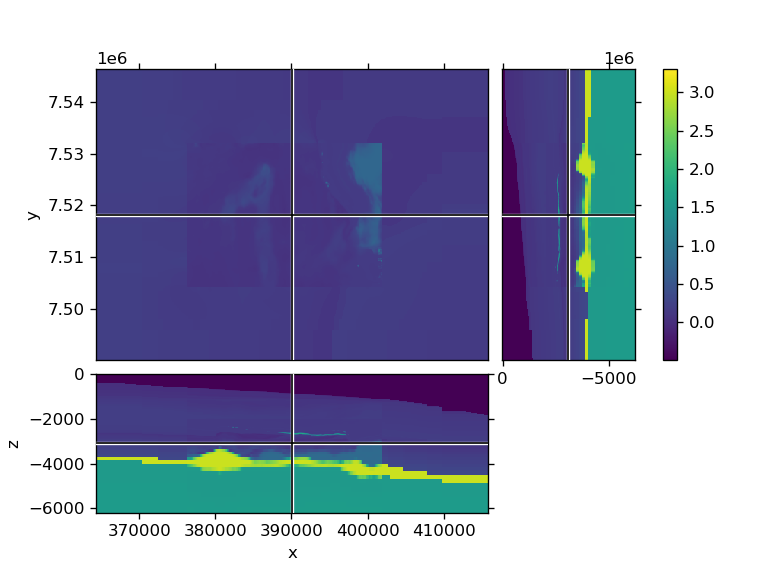

In [4]:
# Create model instance
input_model = emg3d.Model(input_mesh, property_x=input_res_h, property_z=input_res_v, mapping='Resistivity')

del data, tres_h, tres_v, input_res_h, input_res_v

# QC resistivities
input_mesh.plot_3d_slicer(np.log10(input_model.property_x), clim=[np.log10(0.32), np.log10(2000)])

# QC anisotropies
# input_mesh.plot_3d_slicer(np.sqrt(input_model.property_z/input_model.property_x))

## Load survey

In [5]:
ds = xr.load_dataset('../marlim_survey.nc', engine='h5netcdf')
# data = xr.load_dataset('../marlim_data.nc', engine='h5netcdf')

### Extract required info

In [6]:
# Use reciprocity: rec becomes src
src = [ds.rec_x, ds.rec_y, ds.rec_z,
       ds.rec_theta, ds.rec_dip]

# Use reciprocity: src becomes rec
rec_x = ds.data_il.src_x[::2]
rec_y_il = ds.data_il.src_y
rec_z_il = ds.data_il.src_z

# Ensure same coordinates
print(np.allclose(rec_x, ds.data_bs.src_x[::2]))

rec_y_bs = ds.data_bs.src_y
rec_z_bs = ds.data_bs.src_z

# Frequency
freqs = ds.freqs.values

True


## Computation mesh

### x-diretion

In [7]:
oNx = input_mesh.vectorNx

# Computational mesh from min(rec)-600m to max(rec)+600m
isx = np.argmin(abs(oNx-(rec_x.values.min()-600)))
iex = np.argmin(abs(oNx-(rec_x.values.max()+600)))

x_ext = np.array([300, 450, 675, 1012, 1519, 2278,
                  3417, 5126, 7689, 11533, 17300])

hx = np.r_[x_ext[::-1], np.ones(32)*200, 170, 130, np.ones(102)*100, 130, 170, np.ones(32)*200, x_ext]
x0 = oNx[isx]-x_ext.sum()

# oNx[isx], oNx[iex], isx, iex-isx, x_ext.sum()

### y-direction

In [8]:
# Using in-built function

# Get cell widths and origin in each direction
minres = input_model.property_x.min()
maxres = input_model.property_z[input_model.property_z<1e7].max()
y0, hy = emg3d.meshes.origin_and_widths(  # -63 align with inp mesh
    frequency=freqs.min(), max_buffer=50000,
    properties=[minres, maxres], center=src[1]-63, domain=[src[1]-3250, src[1]+2100],
    min_width_limits=input_mesh.h[1][0])

### z-direction

In [9]:
# (a) Boundary: Different up and down
z_ext_m = np.array([90, 135, 202, 304, 456, 683, 1025, 1538,
                    2307, 3460, 5190, 7785, 11677, 17516])
z_ext_p = np.array([255, 382, 574, 861, 1291, 1936, 2905,
                    4357, 6535, 9803, 14705, 22057])

# (b) Cell widths
hz = np.r_[
    z_ext_m[::-1],
    np.ones(23)*60,            # -4280 to -2900
    np.ones(46)*40,            # -2900 to -1060
    30, 30,                    # -1060 to -1000
    np.ones(25)*20,            # -1000 to -500
    28.6, 40.8, 58.3, 83.3, 119, 170,  # -500 to 0
    z_ext_p
]

# (c) Origin
z0 = -(hz.sum()-z_ext_p.sum())

In [10]:
# Create a TensorMesh instance.
mesh = emg3d.TensorMesh(h=[hx, hy, hz], origin=[x0, y0, z0])
mesh

TensorMesh: 1,966,080 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    192    327,426.00    453,624.00    100.00 17,300.00    1.50
   y     80  7,464,533.37  7,569,964.63    100.00 16,316.67    1.48
   z    128    -56,648.00     65,661.00     20.00 22,057.00    1.50

In [11]:
# Interpolate to computational mesh
model = input_model.interpolate_to_grid(mesh)

del input_mesh, input_model

# `emg3d` computation

In [12]:
solver_params = {'sslsolver': False, 'verb': 1, 'return_info': True}

# Pre-allocate results-array
egd = np.zeros((2, rec_x.size, 6, 6), dtype=complex)
    
max_mem = 0
tot_time = 0
results = {}

for ii, freq in enumerate(freqs):

    print(f"\n === Frequency {ii+1}/{freqs.size} :: {freq} Hz ===")
    # Source field
    sfield = emg3d.fields.get_source_field(mesh, src, freq)

    mem = %memit -o efield, info = emg3d.solve(model, sfield, tol=1e-6/freq, **solver_params)
    tot_time += info['time']
    ram = (mem.mem_usage[0] - mem.baseline)/1024
    if ram > max_mem:
        max_mem = ram

    # Save full field after each iteration
    # (if something aborts the loop the previous are still on disk)
    results[str(freq)] = efield
    emg3d.save('fullfields.h5', results=results, mesh=mesh, verb=0)

    # Get h-field
    hfield = emg3d.fields.get_magnetic_field(model, efield)

    # Extract (interpolate) fields at receiver locations from the emg3d result.
    for i, rec in enumerate(zip([rec_y_il, rec_y_bs], [rec_z_il, rec_z_bs])):
        # Electric fields
        egd[i, :, ii, 0] = efield.get_receiver((rec_x, rec[0], rec[1], 0, 0))  # Ex
        egd[i, :, ii, 1] = efield.get_receiver((rec_x, rec[0], rec[1], 90, 0))  # Ey
        egd[i, :, ii, 2] = efield.get_receiver((rec_x, rec[0], rec[1], 0, 90))  # Ez
        # Magnetic fields
        egd[i, :, ii, 3] = hfield.get_receiver((rec_x, rec[0], rec[1], 0, 0))  # Hx
        egd[i, :, ii, 4] = hfield.get_receiver((rec_x, rec[0], rec[1], 90, 0))  # Hy
        egd[i, :, ii, 5] = hfield.get_receiver((rec_x, rec[0], rec[1], 0, 90))  # Hz

time = f"{tot_time:.0f} s"
ram = f"{max_mem:.3f} GiB"
print(f"\ntime: {time}; memory usage: {ram}")


 === Frequency 1/6 :: 0.125 Hz ===
:: emg3d :: 5.2e-06; 8; 0:03:50; CONVERGED
peak memory: 1867.67 MiB, increment: 493.82 MiB

 === Frequency 2/6 :: 0.25 Hz ===
:: emg3d :: 2.1e-06; 8; 0:04:16; CONVERGED
peak memory: 1958.00 MiB, increment: 433.77 MiB

 === Frequency 3/6 :: 0.5 Hz ===
:: emg3d :: 1.7e-06; 7; 0:03:32; CONVERGED
peak memory: 2056.86 MiB, increment: 472.55 MiB

 === Frequency 4/6 :: 0.75 Hz ===
:: emg3d :: 7.3e-07; 7; 0:03:45; CONVERGED
peak memory: 2146.43 MiB, increment: 486.40 MiB

 === Frequency 5/6 :: 1.0 Hz ===
:: emg3d :: 3.5e-07; 7; 0:03:41; CONVERGED
peak memory: 2243.93 MiB, increment: 478.86 MiB

 === Frequency 6/6 :: 1.25 Hz ===
:: emg3d :: 6.8e-07; 5; 0:02:38; CONVERGED
peak memory: 2333.94 MiB, increment: 478.79 MiB

time: 1302 s; memory usage: 0.482 GiB


In [13]:
# Define receiver as every cell center in the x-z slice of the source-y
rx = np.repeat([mesh.vectorCCx, ], mesh.nCz, axis=0).ravel()
rz = np.repeat([mesh.vectorCCz, ], mesh.nCx, axis=1).ravel()
rec_coords = (rx, rec_y_bs.data, rz)

# fx field
fx = results['1.0'].get_receiver((*rec_coords, 0, 0))
fx = fx.reshape((mesh.nCx, mesh.nCz), order='F')

# fy field
fy = results['1.0'].get_receiver((*rec_coords, 90, 0))
fy = fy.reshape((mesh.nCx, mesh.nCz), order='F')

# Save fields and mesh
emg3d.save('../results/emg3d_meshesfields.h5', mesh=mesh, fx=fx, fy=fy)

Data saved to «/home/dtr/Codes/article-os-csem/model-marlim/results/emg3d_meshesfields.h5»
[emg3d v1.2.1 (format 1.0) on 2021-09-24T10:49:39.086223].


In [14]:
# Save the two lines
ds.data_il.data[::2, :, :] = egd[0, :, :, :].real  # Inline RE
ds.data_il.data[1::2, :, :] = egd[0, :, :, :].imag  # Inline IM

ds.data_bs.data[::2, :, :] = egd[1, :, :, :].real  # Broadside RE
ds.data_bs.data[1::2, :, :] = egd[1, :, :, :].imag  # Broadside IM

# Add info
ds.attrs['runtime'] = time
ds.attrs['n_procs'] = 1
ds.attrs['max_ram'] = ram
ds.attrs['n_cells'] = f"({mesh.nCx} x {mesh.nCy} x {mesh.nCz}) - {mesh.nC}"
ds.attrs['n_nodes'] = 'N/A'
ds.attrs['n_dof'] = mesh.nE
ds.attrs['extent'] = (f"x = {mesh.vectorNx[0]:.1f}-{mesh.vectorNx[-1]:.1f}; " # Total mesh extent
                      f"y = {mesh.vectorNy[0]:.1f}-{mesh.vectorNy[-1]:.1f}; "
                      f"z = {mesh.vectorNz[0]:.1f}-{mesh.vectorNz[-1]:.1f}")
ds.attrs['min_vol'] = f"{np.min(mesh.vol):.1f}"
ds.attrs['max_vol'] = f"{np.max(mesh.vol):.1f}"
ds.attrs['machine'] = "Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 20.04"
ds.attrs['version'] = f"emg3d v{emg3d.__version__}"
ds.attrs['date'] = datetime.today().isoformat()

# Save it under <{model}_{code}.nc>
ds.to_netcdf(f"../results/marlim_emg3d.nc", engine='h5netcdf')
ds

<xarray.Dataset>
Dimensions:     (components: 6, src_x: 408, freqs: 6)
Coordinates:
  * components  (components) object b'Ex' b'Ey' b'Ez' b'Hx' b'Hy' b'Hz'
  * freqs       (freqs) float32 0.125 0.25 0.5 0.75 1.0 1.25
  * src_x       (src_x) float32 3.794e+05 3.794e+05 ... 4.012e+05 4.012e+05
Data variables:
    data_bs     (src_x, freqs, components) float64 -1.017e-14 ... 1.41e-17
    data_il     (src_x, freqs, components) float64 -1.043e-14 ... 8.014e-17
Attributes: (12/20)
    date:       2021-09-24T10:50:41.586034
    extent:     x = 327426.0-453624.0; y = 7464533.4-7569964.6; z = -56648.0-...
    machine:    Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 2...
    max_ram:    0.482 GiB
    max_vol:    6226215345695.3
    min_vol:    200000.0
    ...         ...
    rec_z:      -849.7838
    runtime:    1302 s
    src_dip:    0.0
    src_theta:  0.0
    strength:   1.0
    version:    emg3d v1.2.1

## Figure 4 from Correa and Menezes (2019), but noise-free data

In [15]:
data = xr.load_dataset('../marlim_data.nc', engine='h5netcdf')

<IPython.core.display.Javascript object>


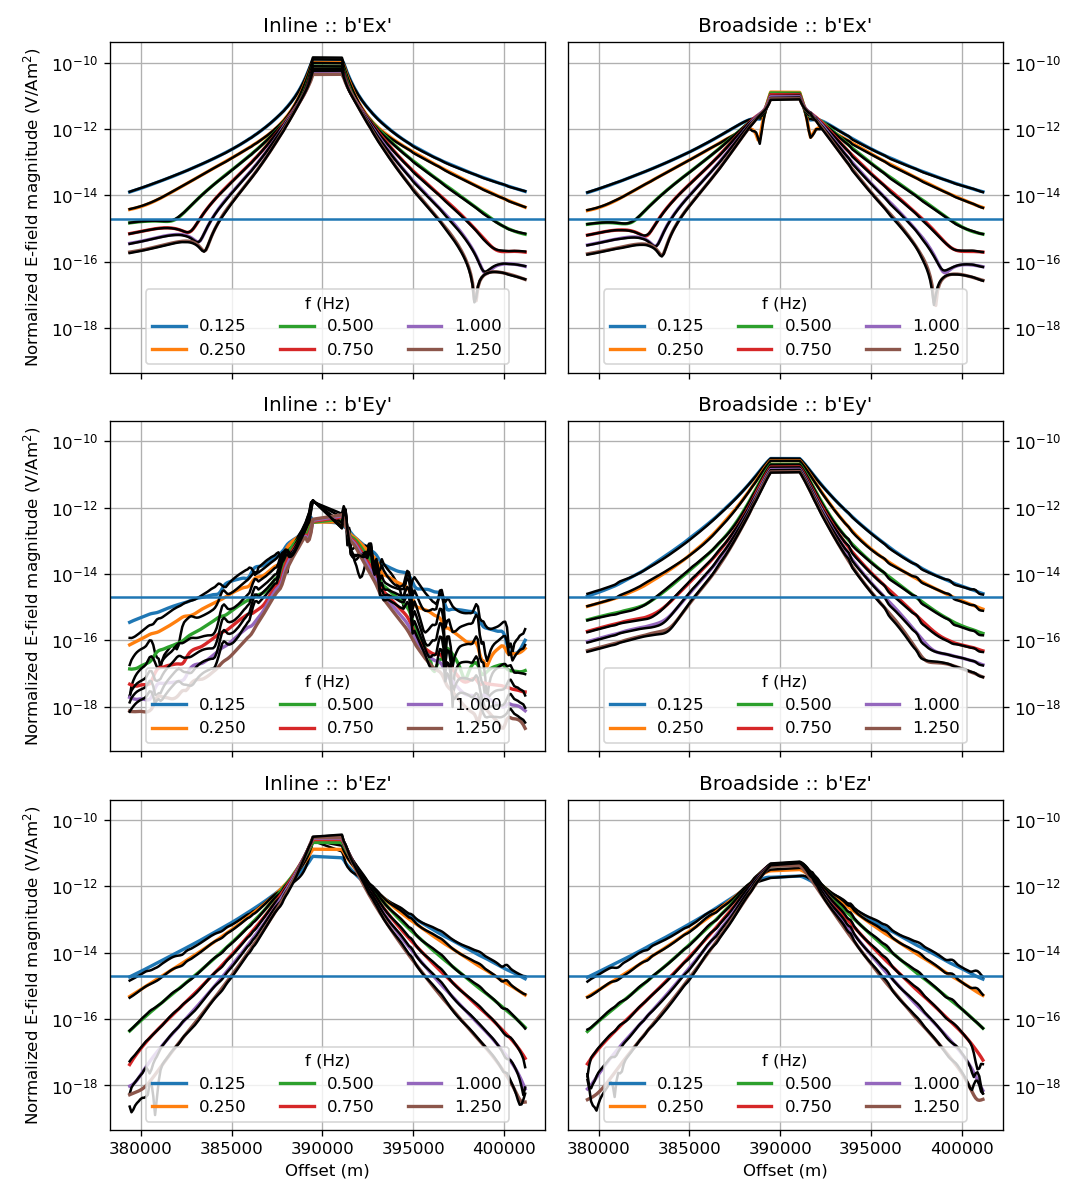

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharex=True, sharey=True)

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Take absolute value
    tdat = np.abs(getattr(data, datname).data[::2, :, :] +
                  1j*getattr(data, datname).data[1::2, :, :])

    # Loop over components Ex, Ey, Ez
    for ii, comp in enumerate(data.components.values[:3]):

        plt.sca(axs[ii, iii])
        plt.title(f"{['Inline', 'Broadside'][iii]} :: {comp}")

        # Loop over frequencies
        for i, freq in enumerate(data.freqs.values):

            # Plot this component/frequency
            plt.plot(rec_x, tdat[:, i, ii], f"C{i}", lw=2, label=f"{freq:4.3f}")
            plt.plot(rec_x, abs(egd[iii, :, i, ii]), 'k-')

        plt.axhline(2e-15)
        plt.legend(title='f (Hz)', loc='lower center', ncol=3)
        plt.grid('on')
        plt.yscale('log')
        
        if ii == 2:
            plt.xlabel('Offset (m)')
        if iii == 0:
            plt.ylabel('Normalized E-field magnitude (V/Am$^2$)')
        else:
            axs[ii, iii].yaxis.set_ticks_position('right')
            axs[ii, iii].yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

In [17]:
emg3d.save('../results/emg3d_model.h5', model=model, mesh=mesh)

Data saved to «/home/dtr/Codes/article-os-csem/model-marlim/results/emg3d_model.h5»
[emg3d v1.2.1 (format 1.0) on 2021-09-24T10:24:05.317562].


In [18]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Fri Sep 24 10:24:06 2021 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:38)
  [GCC 7.3.0]

             numpy : 1.20.3
             scipy : 1.7.1
             numba : 0.54.0
             emg3d : 1.2.1
           empymod : 2.1.2
            xarray : 0.19.0
        discretize : 0.7.0
              h5py : 3.3.0
        matplotlib : 3.4.3
              tqdm : 4.62.3
           IPython : 7.27.0

  Intel(R) Math Kernel Library Version 2020.0.4 Product Build 20200917 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------